In [33]:
import sys
import networkx as nx
import re
import matplotlib.pyplot as plt
%matplotlib inline

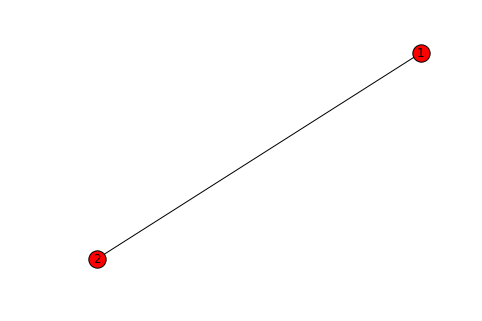

{1: 1, 2: 1}


In [7]:
G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_edge(1,2)
nx.draw(G,with_labels='true')
plt.show()
print G.degree()
# help(G.add_node)
#from pylab import *
# plt.plot([1,2,3])
# plt.show()

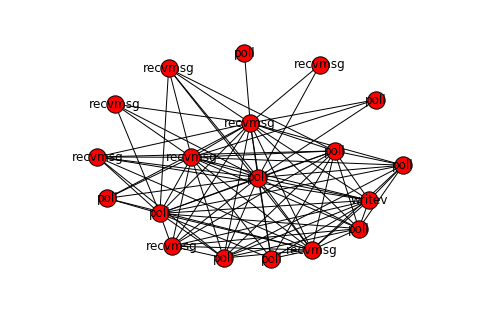

In [51]:
# fname = "gimp_detailed2.txt"
# f_initial = "Gimp_screenshot_details"
# f_common  = "gimp_common_details.txt"


# fname = "shutter_detailed2.txt"
# f_initial = "shutter_screenshot_details.txt"
# f_common  = "shutter_common_details.txt"

fname = "screenshot_detailed2.txt"
f_initial = "screenshot_details.txt"
f_common  = "screenshot_common_details.txt"

G = nx.Graph()
G2 = nx.Graph()
inputs_array=[]
outputs_array=[]
instructions_array=[]

def common_syscalls():
    f = open(f_initial,'r')
    #Read the line
    line = f.readline()
    common = open(f_common,"w")

    valid_syscalls=["read","poll","munmap","clone","writev","open","recvmsg","lseek","close","brk","lstat","fstat","fcntl","readlink","uname"]
    #Read the file line by line
    while line:
        line = f.readline()
        common_syscall = line.partition("(")[0]
        if (common_syscall in valid_syscalls):
            common.write(line)

    f.close()
    common.close()

# common_syscalls()

#Delete recvmsg commands that outputted resource temporarily unavailable
def recvmsg_edit():

    f_read = open(f_common,"r")
    f_write = open(fname,"w+")

    line = f_read.readline()

    while line:
        line =f_read.readline()
        # print "as"
        recvmsg_output = line.partition("=")[2]
        # print recvmsg_output
        # f_write.write(recvmsg_output)
        if ("EAGAIN" not in recvmsg_output):
            f_write.write(line)

    f_read.close()
    f_write.close()

# recvmsg_edit()
# Make an instruction object with attributes - inputs, output, sequence number, instruction type

############################################################################################################
#Object Declarations
class Instruction_Object:

    def __init__(self,output,sequence_no,instruction_type,inputs =[]):
        self.inputs = inputs
        self.output = output
        self.sequence_no = sequence_no
        self.instruction_type=instruction_type
        return
    
    def __repr__(self):
        return self.instruction_type

#Classes for input arguments and outputs of the strace calls
class argument_object:

    def __init__(self,data_type,sequence,arguments=[]):
        self.arguments = arguments
        self.data_type = data_type
        self.sequence = sequence
        return

class output_object:

    def __init__(self,output,sequence,data_type):
        self.output =output
        self.data_type = data_type
        self.sequence=sequence
        return

############################################################################################################



#Extracts output of a line
def extract_output(line):
    #Get arguments on the right of '='
    line_partition = re.findall('\s=\s(\w.*)',line)
    if (line_partition):
        line_partition=line_partition[0]
    return line_partition


#Gets entire output from extract_output and retains only the relevant output
def process_output(line):
    str_out = extract_output(line)
    if ("fd" in str_out):
        output =re.findall('fd=(\d*)',str_out)
        output_type = 'fd'
    elif ("0x" in str_out):
        output =re.findall('0x(\w*)',str_out)
        output_type = 'address'
    else:
        output = '0'
        output_type='0'
    return output,output_type


############################################################################################################

#Outputs length of file
def file_len(fname):
    # fname = "gimp_detailed2.txt"
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return 20
# 	return (i+1)

#Debugging purposes,
def print_output():
    f = open(fname,"r")
    line = f.readline()
    for i in xrange(file_len(fname)):
        line = f.readline()
        line_temp = extract_output(line)
        print line_temp
        
def sets_overlap(a,b):
    for i in a:
        if i in b:
            return True
    return False

def sets_overlap2(a,b,c):
    for i in a:
        if i in b:
            if i in c:
                return True
    return False
############################################################################################################

#Extracts Instruction from a line
def extract_instruction(line):
    instruction = line.partition("(")[0]
    return instruction

############################################################################################################

#Extract Argument from a line
#Requirements: 
#line has to be in single quotes
def extract_argument(line):
    argument_array =[]
    input_type='0'
    instruction = extract_instruction(line)
    #If instruction is read
    if (instruction=='read'):
        fd = line.partition("(")[2]
        fd = fd.partition(",")[0]
        argument_array.append(fd)
        input_type = 'fd'

    # munmap(0x7fccc19ab000, 200704)          = 0
    if (instruction=='munmap'):
        address = line.partition("(")[2]
        address = address.partition(",")[0]
        argument_array.append(address)
        input_type = 'address'


# poll([{fd=4, events=POLLIN}, {fd=3, events=POLLIN}, {fd=5, events=POLLIN}, {fd=10, events=POLLIN|POLLPRI}], 4, 0) = 0 (Timeout)
    if (instruction=='poll'):
        fd = re.findall('fd=(\d*)',line)
        argument_array.append(fd)
        input_type = 'fd'

#recvmsg(3, {msg_name(0)=NULL, msg_iov(1)=[{"\1\1?[\0\0\0\0\213\22\340\1\310\0\305\1\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0", 4096}], msg_controllen=0, msg_flags=0}, 0) = 32
    if (instruction=='recvmsg'):
        fd =re.findall(r'\d{1,20}',line)
        fd = fd[0]
        argument_array.append(fd)
        input_type='fd'

    #clone(child_stack=0, flags=CLONE_CHILD_CLEARTID|CLONE_CHILD_SETTID|SIGCHLD, child_tidptr=0x7fcce289dc90) = 7399
    if (instruction=='clone'):
        address =re.findall('0x(\w*)',line)[0]
        argument_array.append(address)
        input_type = 'address'

    #writev(3, [{"+\0\1\0", 4}, {NULL, 0}, {"", 0}], 3) = 4
    if (instruction=='writev'):
        fd =re.findall(r'\d{1,20}',line)
        fd = fd[0]
        argument_array.append(fd)
        input_type = 'fd'

    #open("/usr/lib/gimp/2.0/plug-ins/screenshot", O_RDONLY) = 17
    if (instruction =='open'):
        temp_path = line.partition('(')[2]
        new_path = temp_path.split(",")
        path = new_path[0]
        argument_array.append(path)
        input_type = 'path'

    #close(17)                               = 0
    if (instruction =='close'):
        fd =re.findall(r'\d{1,20}',line)
        fd = fd[0]
        argument_array.append(fd)
        input_type = 'fd'

    #brk(0x3ac6000)                          = 0x3ac6000
    if(instruction =='brk'):
        address =re.findall('0x(\w*)',line)[0]
        argument_array.append(address)
        input_type='address'

    #In fstat, I have not taken into account st_mode. 
    #fstat(14, {st_mode=S_IFIFO|0600, st_size=0, ...}) = 0

    if (instruction=='fstat'):
        fd =re.findall(r'\d{1,20}',line)
        fd = fd[0]
        argument_array.append(fd)
        input_type ='fd'

    #I haven't taken into account the WRONLY and RDONLY Flags. Might help to take that into account
    #fcntl(14, F_GETFL)                      = 0x1 (flags O_WRONLY)
    if (instruction=='fcntl'):
        fd =re.findall(r'\d{1,20}',line)
        fd = fd[0]
        argument_array.append(fd)
        input_type='fd'

    #Removing nested loops
    if (any(isinstance(i,list) for i in argument_array)==True):
        return argument_array[0],input_type
    else:
        return argument_array,input_type

############################################################################################################


#Make all objects and assign them
def make_objects(fname):
    f = open(fname,'r')
    line = f.readline()
    count = 0
    while line:
        line = f.readline()
        sequence = count
        args,arg_type = extract_argument(line)
        out,out_type = process_output(line)
        instr_type = extract_instruction(line)
        instr_obj = Instruction_Object(instruction_type = instr_type,inputs = args, sequence_no= sequence,output= out)
        instructions_array.append(instr_obj)
        arg_object = argument_object(data_type=arg_type,sequence=count,arguments=args)
        inputs_array.append(arg_object)
        out_object = output_object(output=out,sequence=count,data_type=out_type)
        outputs_array.append(out_object)
        count = count+1
    f.close()


make_objects(fname)


#Draw edges function
def make_Edges_Arguments(instructions_array,inputs_array,outputs_array):
    for inst in instructions_array[:file_len(fname)-10]:
        for j in xrange(10):
            G.add_node(inst.instruction_type)
            next_inst = instructions_array[inst.sequence_no+j]
            overlap_bool = sets_overlap(inputs_array[inst.sequence_no].arguments,inputs_array[inst.sequence_no+j].arguments)
            if (overlap_bool):
                G.add_edge(inst,next_inst)

#Function that makes an edge if output of one is the input of another                
def make_Edges_OutIn(instructions_array,inputs_array,outputs_array):
    for inst in instructions_array[:file_len(fname)-10]:
        for j in xrange(1,10):
            G.add_node(inst.instruction_type)
            next_inst = instructions_array[inst.sequence_no+j]
            overlap_bool = sets_overlap(outputs_array[inst.sequence_no].output,inputs_array[inst.sequence_no+j].arguments)
            if (overlap_bool):
                G.add_edge(inst,next_inst)
#                 print inst.instruction_type, inst.sequence_no
#                 print inst.output, inst.inputs
#                 print "next instruction"
#                 print next_inst.instruction_type, next_inst.sequence_no
#                 print next_inst.inputs, next_inst.output
#                 print "##########"

#Function that makes an edge if they share arguments or share input/output
def make_Edges_OutInArg(instructions_array,inputs_array,outputs_array):
    for inst in instructions_array[:file_len(fname)-10]:
        for j in xrange(1,10):
            G.add_node(inst.instruction_type)
            next_inst = instructions_array[inst.sequence_no+j]
            overlap_bool = sets_overlap(outputs_array[inst.sequence_no].output,inputs_array[inst.sequence_no+j].arguments)
            overlap_bool2 = sets_overlap(inputs_array[inst.sequence_no].arguments,inputs_array[inst.sequence_no+j].arguments)
            if (overlap_bool or overlap_bool2):
                G.add_edge(inst,next_inst)

# make_Edges_Arguments(instructions_array,inputs_array,outputs_array)
# make_Edges_OutIn(instructions_array,inputs_array,outputs_array)
make_Edges_OutInArg(instructions_array,inputs_array,outputs_array)

to_remove = [n for n in degree if degree[n]==0]
G.remove_nodes_from(to_remove)
pos=nx.spring_layout(G,k=.6)
nx.draw(G,with_labels ='true', pos=pos)
plt.show()





In [7]:
x = [1,2,3,4,5,56,6,77,8,8,9,19]
x[:]


[1, 2, 3, 4, 5, 56, 6, 77, 8, 8, 9, 19]